In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader
import torch.optim as optim
import numpy as np
import os 
import matplotlib.pyplot as plt
import torch.nn.functional as F


In [20]:
batch_size = 128
num_classes = 10
latent_dim = 100
img_size = 28
img_shape = (1,img_size,img_size)
batch_size = 64
epochs = 100
sample_interval = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5])
])

In [4]:
dataset = datasets.MNIST('.', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset,batch_size=batch_size, shuffle=True)

In [5]:
class GeneratorV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.label_emb = nn.Embedding(num_classes,num_classes)
        
        self.model = nn.Sequential(
            nn.Linear(latent_dim + num_classes, 128),
            nn.ReLU(True),
            nn.Linear(128,256),
            nn.BatchNorm1d(256),
            nn.ReLU(True),
            nn.Linear(256,512),
            nn.BatchNorm1d(512),
            nn.ReLU(512),
            nn.Linear(512, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self,noise,labels):
        label_input = self.label_emb(labels)
        x = torch.cat([noise,label_input], dim=1)
        img = self.model(x)
        return img.view(img.size(0), *img_shape)
    
class DiscriminatorV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.label_emb = nn.Embedding(num_classes,num_classes)

        self.model = nn.Sequential(
            nn.Linear(num_classes + int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512,256),
            nn.LeakyReLU(0.2),
            nn.Linear(256,1),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        label_input = self.label_emb(labels)
        x = torch.cat([img.view(img.size(0), -1), label_input], dim=1)
        validity = self.model(x)
        return validity


In [6]:
import torch.nn.functional as F

class GeneratorV2(nn.Module):
    def __init__(self, latent_dim=100, num_classes=10):
        super().__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        self.project = nn.Linear(latent_dim + num_classes, 128 * 7 * 7)

        self.gen = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),  
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),   
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.Conv2d(32, 1, 3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, noise, label):
        label_onehot = F.one_hot(label, num_classes=self.num_classes).float()
        x = torch.cat([noise, label_onehot], dim=1) 
        x = self.project(x)  
        x = x.view(-1, 128, 7, 7) 
        img = self.gen(x)
        return img

class DiscriminatorV2(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.num_classes = num_classes

        self.model = nn.Sequential(
            nn.Conv2d(2, 32, kernel_size=3, stride=2, padding=1),  
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),

            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), 
            nn.ZeroPad2d((0, 1, 0, 1)), 
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1), 
            nn.LeakyReLU(0.2, inplace=True),

            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 1),
            nn.Sigmoid()
        )

    def forward(self, img, label):
        label_map = F.one_hot(label, num_classes=self.num_classes).float()  # [B, 10]
        label_map = label_map.view(label.size(0), self.num_classes, 1, 1)
        label_map = label_map.expand(-1, -1, 28, 28)  # [B, 10, 28, 28]
        label_channel = label_map.sum(dim=1, keepdim=True) / self.num_classes  # [B, 1, 28, 28]

        x = torch.cat([img, label_channel], dim=1)  # [B, 2, 28, 28]
        return self.model(x)


In [7]:
generator = GeneratorV2().to(device)
discriminator = DiscriminatorV2().to(device)


In [18]:
adversarial_loss = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002)

In [9]:
loss_list_D= []
loss_list_G = []

In [21]:
for epoch in range(epochs):
    for imgs, labels in dataloader:
        batch_size = imgs.size(0)
        real = torch.ones(batch_size, 1, device=device)
        fake = torch.zeros(batch_size, 1, device=device)

        imgs, labels = imgs.to(device), labels.to(device)

        #Train Generator
        z = torch.randn(batch_size,latent_dim,device=device)
        gen_labels = torch.randint(0, num_classes, (batch_size,), device=device)
        gen_imgs = generator(z,gen_labels)
        validity = discriminator(gen_imgs, gen_labels)
        g_loss = adversarial_loss(validity, real)

        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

        real_loss = adversarial_loss(discriminator(imgs,labels), real)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach(), gen_labels), fake)
        d_loss = (real_loss + fake_loss) / 2

        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

        print(f"[Epoch {epoch+1}/{epochs}] D loss: {d_loss.item():.4f} | G loss: {g_loss.item():.4f}")

        if (epoch + 1) % sample_interval == 0:
            generator.eval()
            z = torch.randn(10, latent_dim, device=device)
            labels = torch.arange(0, 10, device=device)
            gen_imgs = generator(z, labels).detach().cpu()
            grid = utils.make_grid(gen_imgs, nrow=10, normalize=True)
            os.makedirs("images_CNN", exist_ok=True)
            utils.save_image(grid, f"images_CNN/epoch_{epoch+1}.png")
            generator.train()
            
    loss_list_D.append(d_loss.data.cpu().numpy())
    loss_list_G.append(g_loss.data.cpu().numpy())


torch.save(generator.state_dict(), "generator_CNN.pth")
torch.save(discriminator.state_dict(), "discriminator_CNN.pth")

print("Training complete.")

        
        


[Epoch 1/100] D loss: 0.4937 | G loss: 1.1156
[Epoch 1/100] D loss: 0.6092 | G loss: 1.4564
[Epoch 1/100] D loss: 0.5597 | G loss: 1.1138
[Epoch 1/100] D loss: 0.5679 | G loss: 1.2017
[Epoch 1/100] D loss: 0.4928 | G loss: 1.2537
[Epoch 1/100] D loss: 0.5416 | G loss: 1.2837
[Epoch 1/100] D loss: 0.5015 | G loss: 1.1481
[Epoch 1/100] D loss: 0.6558 | G loss: 1.1609
[Epoch 1/100] D loss: 0.5531 | G loss: 1.2240
[Epoch 1/100] D loss: 0.5929 | G loss: 1.1093
[Epoch 1/100] D loss: 0.4694 | G loss: 1.4462
[Epoch 1/100] D loss: 0.5194 | G loss: 1.1124
[Epoch 1/100] D loss: 0.7304 | G loss: 1.0836
[Epoch 1/100] D loss: 0.4802 | G loss: 1.3008
[Epoch 1/100] D loss: 0.5367 | G loss: 1.2134
[Epoch 1/100] D loss: 0.5006 | G loss: 1.2329
[Epoch 1/100] D loss: 0.5300 | G loss: 1.0608
[Epoch 1/100] D loss: 0.6250 | G loss: 1.1876
[Epoch 1/100] D loss: 0.5236 | G loss: 1.1478
[Epoch 1/100] D loss: 0.5174 | G loss: 1.3126
[Epoch 1/100] D loss: 0.4132 | G loss: 1.5109
[Epoch 1/100] D loss: 0.6538 | G l

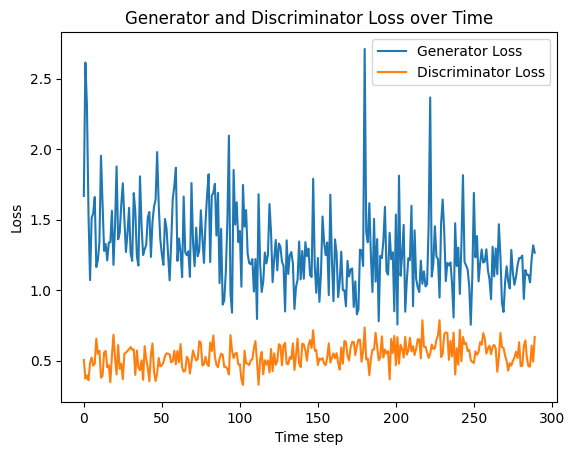

In [22]:
time = list(range(len(loss_list_G)))

plt.plot(time, loss_list_G, label='Generator Loss')
plt.plot(time, loss_list_D, label='Discriminator Loss')

plt.xlabel('Time step')
plt.ylabel('Loss')
plt.title('Generator and Discriminator Loss over Time')
plt.legend()

plt.show()